<a href="https://colab.research.google.com/github/Spoorthy-Siddannaiah/Sensor_data_roboticarm/blob/main/sensordata_analysis_roboticarm.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# --- 1.Requirements ---

!pip install hmmlearn



   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 165.9/165.9 kB 3.0 MB/s eta 0:00:00


# **K-Means Clustering for Task Segmentation of Robot Movements**

In this section K-means clustering is applied to the preprocessed data of a robot's movements. By segmenting the data using a sliding window, extracting statistical features, and performing dimensionality reduction with PCA, the data is clustered into different states. These states correspond to different tasks performed by the robot.(calibration, stone, dance, gripper rotataion and motionaless pause)

In [ ]:
# --- 1. Import Libraries ---
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score, davies_bouldin_score
from hmmlearn.hmm import GaussianHMM
import matplotlib.lines as mlines

In [ ]:
# --- 2. Load and Preprocess Data ---
sns.set(style="whitegrid")
data = pd.read_csv('/content/xdk_robot_demo_hand2_3Hz_original.csv')
data['acceleration_magnitude'] = np.sqrt(data['acceleration_x']**2 + data['acceleration_y']**2 + data['acceleration_z']**2)
data['orientation_magnitude'] = np.sqrt(data['orientation_x']**2 + data['orientation_y']**2 + data['orientation_z']**2 + data['orientation_w']**2)
data['time_sec'] = data.index / 3.0

# Set time as index
data.set_index('time_sec', inplace=True)

In [ ]:
data.shape

(2956, 13)

In [ ]:
# --- 3. Segment Data with Sliding Window ---
SAMPLING_RATE = 3
WINDOW_SIZE = 5 * SAMPLING_RATE
STRIDE = 2 * SAMPLING_RATE
sensor_columns = ['temperature', 'light', 'humidity', 'pressure', 'acceleration_magnitude', 'orientation_magnitude']

def sliding_window_segment(data, window_size, stride):
    return [data.iloc[start:start+window_size] for start in range(0, len(data) - window_size + 1, stride)]

def extract_features(segment):
    return {
        f'{col}_{stat}': func(segment[col])
        for col in sensor_columns
        for stat, func in [('mean', np.mean), ('std', np.std), ('min', np.min), ('max', np.max)]
    }

segments = sliding_window_segment(data, WINDOW_SIZE, STRIDE)
features_df = pd.DataFrame([extract_features(seg) for seg in segments])

In [ ]:
features_df.columns

Index(['temperature_mean', 'temperature_std', 'temperature_min',
       'temperature_max', 'light_mean', 'light_std', 'light_min', 'light_max',
       'humidity_mean', 'humidity_std', 'humidity_min', 'humidity_max',
       'pressure_mean', 'pressure_std', 'pressure_min', 'pressure_max',
       'acceleration_magnitude_mean', 'acceleration_magnitude_std',
       'acceleration_magnitude_min', 'acceleration_magnitude_max',
       'orientation_magnitude_mean', 'orientation_magnitude_std',
       'orientation_magnitude_min', 'orientation_magnitude_max'],
      dtype='object')

In [ ]:
# --- 4. Standardize + PCA + K-Means ---
selected_features = [f'{col}_std' for col in sensor_columns]

scaled_features = StandardScaler().fit_transform(features_df[selected_features])


scaled_feature_df = pd.DataFrame(scaled_features, columns=selected_features)

pca_features = PCA(n_components=2).fit_transform(scaled_features)

kmeans = KMeans(n_clusters=5, random_state=42)

cluster_labels = kmeans.fit_predict(pca_features)

# Add clusters to the dataframe
scaled_feature_df['cluster'] = cluster_labels

In [ ]:
scaled_feature_df.columns

Index(['temperature_std', 'light_std', 'humidity_std', 'pressure_std',
       'acceleration_magnitude_std', 'orientation_magnitude_std', 'cluster'],
      dtype='object')

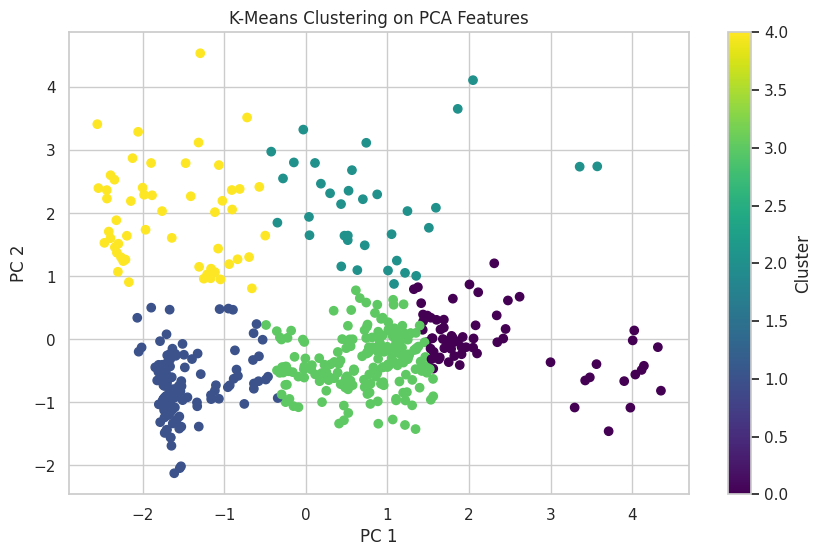

In [ ]:
# --- 5. Visualize Clusters ---
plt.figure(figsize=(10, 6))
plt.scatter(pca_features[:, 0], pca_features[:, 1], c=cluster_labels, cmap='viridis')
plt.title('K-Means Clustering on PCA Features')
plt.xlabel('PC 1')
plt.ylabel('PC 2')
plt.colorbar(label='Cluster')
plt.show()

In [ ]:
# --- 6. Evaluate Clustering ---
print(f"Silhouette Score: {silhouette_score(pca_features, cluster_labels):.3f}")


Silhouette Score: 0.473


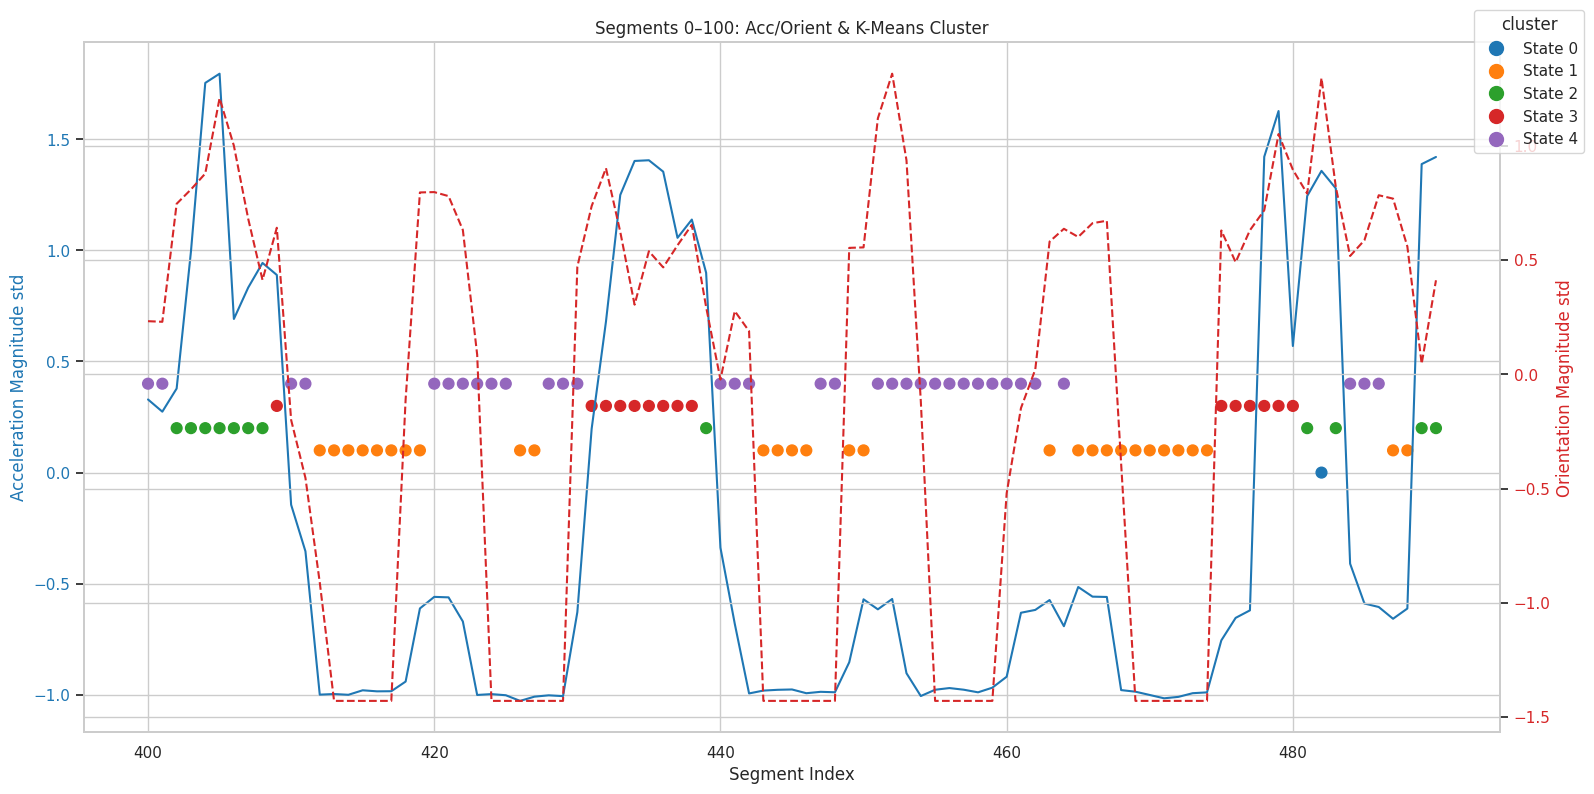

In [ ]:
# --- 7. Visualize clusters Over sensor data ---

import matplotlib.pyplot as plt
import numpy as np
import matplotlib.lines as mlines
from matplotlib.colors import ListedColormap

def plot_states_overlay(df, start, end, state_col, title):
    """
    Plot Acceleration Magnitude and Orientation Magnitude with overlayed cluster labels
    from a specified column, using a
    discrete colormap so legend colors match exactly.
    """
    all_states = np.unique(df[state_col])
    n_states = len(all_states)


    cmap = ListedColormap(plt.cm.tab10.colors[:n_states])

    fig, ax1 = plt.subplots(figsize=(16, 8))

    # Primary y-axis for acceleration magnitude
    ax1.plot(df.index[start:end],
             df['acceleration_magnitude_std'][start:end],
             label='Acceleration Magnitude std', color='tab:blue')
    ax1.set_xlabel('Segment Index')
    ax1.set_ylabel('Acceleration Magnitude std', color='tab:blue')
    ax1.tick_params(axis='y', labelcolor='tab:blue')

    # Secondary y-axis for orientation magnitude
    ax2 = ax1.twinx()
    ax2.plot(df.index[start:end],
             df['orientation_magnitude_std'][start:end],
             label='Orientation Magnitude std', color='tab:red', linestyle='--')
    ax2.set_ylabel('Orientation Magnitude std', color='tab:red')
    ax2.tick_params(axis='y', labelcolor='tab:red')

    # Overlay the state labels (clusters )
    sc = ax1.scatter(
        df.index[start:end],
        df[state_col][start:end] * 0.1,      # small vertical offset
        c=df[state_col][start:end],
        cmap=cmap,
        vmin=all_states.min(), vmax=all_states.max(),
        s=60
    )

    # Build a legend from the discrete colormap
    handles = []
    for s in all_states:
        handles.append(
            mlines.Line2D([], [], marker='o', color=cmap(s), linestyle='None', markersize=10,
                          label=f"State {int(s)}")
        )

    fig.legend(
        handles=handles,
        loc='upper right',
        bbox_to_anchor=(1,1),
        title=state_col
    )
    plt.title(title)
    plt.tight_layout()
    plt.show()



plot_states_overlay(
    df=scaled_feature_df,
    start=400, end=500,
    state_col='cluster',
    title='Segments 0–100: Acc/Orient & K-Means Cluster'
)



In [ ]:
# --- 8. cluster summary ---

cluster_summary = scaled_feature_df.groupby('cluster')[selected_features].mean()
print(cluster_summary.sort_values('acceleration_magnitude_std'))

         temperature_std  light_std  humidity_std  pressure_std  \
cluster                                                           
1              -0.400083  -0.708978     -0.245805     -0.275734   
4               1.232057  -0.702602      2.047029     -0.158414   
3              -0.231331   0.263440     -0.438368     -0.086052   
2               1.100069  -0.258321      1.067935      1.316273   
0              -0.034899   1.556123     -0.438368      0.297962   

         acceleration_magnitude_std  orientation_magnitude_std  
cluster                                                         
1                         -0.945976                  -1.120703  
4                         -0.767038                  -0.530895  
3                          0.272657                   0.585335  
2                          0.947002                   0.796036  
0                          1.469670                   0.835949  


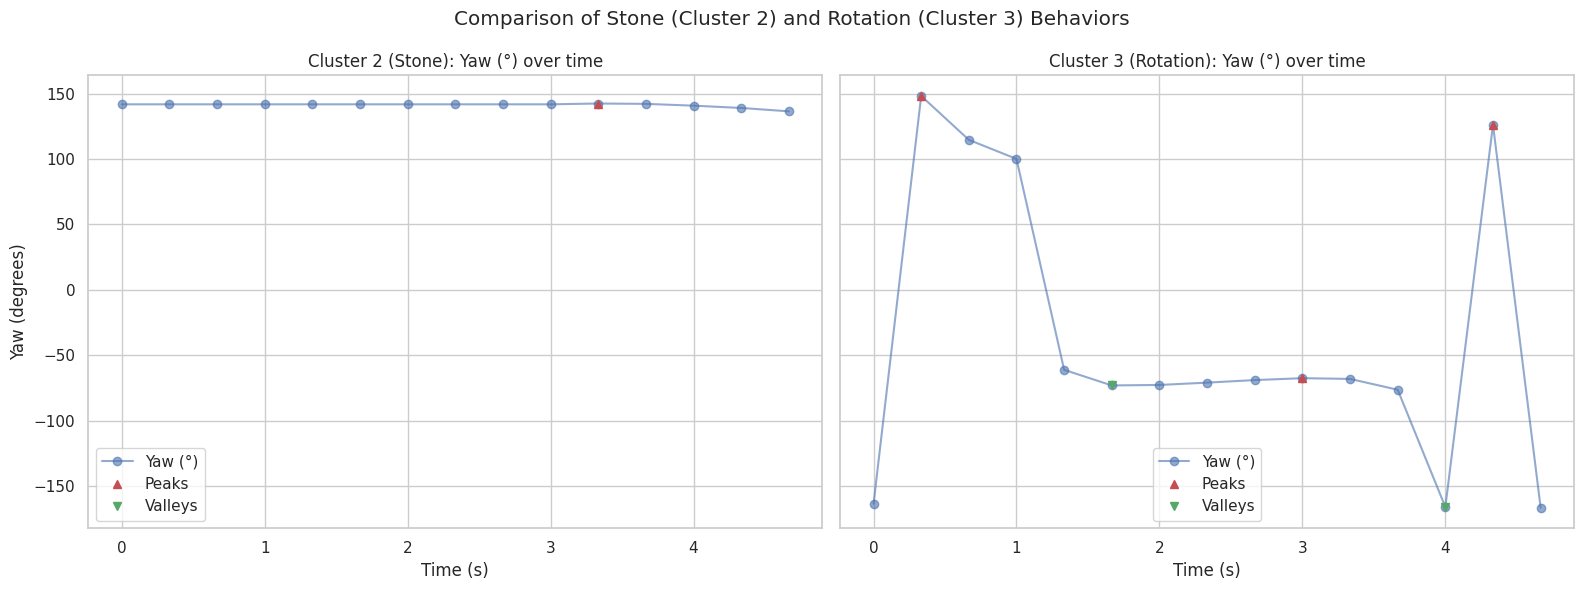

In [ ]:
from scipy.spatial.transform import Rotation as R
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import find_peaks


#  Cluster 2 may represent "Stone" and Cluster 3 may represent "Rotation of Gripper"
cluster_2_id = 2
cluster_3_id = 3

# Pick representative segment indices for each cluster
seg_idx_2 = scaled_feature_df[scaled_feature_df['cluster'] == cluster_2_id].index[0]
seg_idx_3 = scaled_feature_df[scaled_feature_df['cluster'] == cluster_3_id].index[0]

# Extract yaw data for both clusters
raw_2 = segments[seg_idx_2]
raw_3 = segments[seg_idx_3]

# Build quaternions and rotation objects for both clusters
quats_2 = raw_2[['orientation_x', 'orientation_y', 'orientation_z', 'orientation_w']].to_numpy()
quats_3 = raw_3[['orientation_x', 'orientation_y', 'orientation_z', 'orientation_w']].to_numpy()

rot_2 = R.from_quat(quats_2)
rot_3 = R.from_quat(quats_3)

# Extract yaw angles (z-axis rotation) in degrees
euler_2 = rot_2.as_euler('xyz', degrees=True)
euler_3 = rot_3.as_euler('xyz', degrees=True)

yaw_2 = euler_2[:, 2]
yaw_3 = euler_3[:, 2]

# Time axes for both clusters
t_2 = np.arange(len(yaw_2)) / SAMPLING_RATE  # SAMPLING_RATE = 3 Hz
t_3 = np.arange(len(yaw_3)) / SAMPLING_RATE

# Detect peaks and valleys for both clusters
peaks_2, _ = find_peaks(yaw_2)
lows_2, _ = find_peaks(-yaw_2)

peaks_3, _ = find_peaks(yaw_3)
lows_3, _ = find_peaks(-yaw_3)

# Plot side-by-side comparison
fig, axes = plt.subplots(1, 2, figsize=(16, 6), sharey=True)

# Plot Cluster 2 (Stone)
axes[0].plot(t_2, yaw_2, '-o', alpha=0.6, label='Yaw (°)')
axes[0].plot(t_2[peaks_2], yaw_2[peaks_2], 'r^', label='Peaks')
axes[0].plot(t_2[lows_2], yaw_2[lows_2], 'gv', label='Valleys')
axes[0].set_title(f"Cluster {cluster_2_id} (Stone): Yaw (°) over time")
axes[0].set_xlabel("Time (s)")
axes[0].set_ylabel("Yaw (degrees)")
axes[0].legend()
axes[0].grid(True)

# Plot Cluster 3 (Rotation)
axes[1].plot(t_3, yaw_3, '-o', alpha=0.6, label='Yaw (°)')
axes[1].plot(t_3[peaks_3], yaw_3[peaks_3], 'r^', label='Peaks')
axes[1].plot(t_3[lows_3], yaw_3[lows_3], 'gv', label='Valleys')
axes[1].set_title(f"Cluster {cluster_3_id} (Rotation): Yaw (°) over time")
axes[1].set_xlabel("Time (s)")
axes[1].legend()
axes[1].grid(True)

plt.suptitle("Comparison of Stone (Cluster 2) and Rotation (Cluster 3) Behaviors")
plt.tight_layout()
plt.show()

**Cluster 1  → the robot is essentially motionless → “pause.”**

**Cluster 4  →  matches a calibration**

**Cluster 3 --> rotation**

**Cluster 2 ->stone**

**Cluster 0 -->exhibits the highest acceleration ->dance motion**

----
----


# **Hidden Markov Model (HMM) Applied to Sensor Data**

In this section, Hidden Markov Model (HMM) is used to analyze the sensor data by inferring hidden states and interpreting the nature of these states in relation to robot tasks. The approach involves training an HMM model, identifying pauses and active segments, and examining the resulting behavior of the robot. The results are visualized with state overlays on acceleration and orientation data, identifying potential pauses and active phases.

In [ ]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from hmmlearn.hmm import GaussianHMM
import matplotlib.pyplot as plt
import matplotlib.lines as mlines
from matplotlib.colors import ListedColormap

# --- 1) Split Data into Train/Val/Test ---
selected = [
    'temperature_std', 'light_std', 'humidity_std', 'pressure_std',
    'acceleration_magnitude_std', 'orientation_magnitude_std'
]

# Time-based split (60% train, 20% validation, 20% test)
n = len(features_df)
train_end = int(0.6 * n)
val_end = int(0.8 * n)

# Split data (we use only the selected columns)
X_train = features_df[selected][:train_end]
X_val = features_df[selected][train_end:val_end]
X_test = features_df[selected][val_end:]

# --- 2) Standardize Data ---
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled = scaler.transform(X_val)
X_test_scaled = scaler.transform(X_test)

# --- 3) Apply PCA ---
pca = PCA(n_components=2)
X_train_pca = pca.fit_transform(X_train_scaled)
X_val_pca = pca.transform(X_val_scaled)
X_test_pca = pca.transform(X_test_scaled)

# --- 4) Train HMM on Training Set ---
hmm = GaussianHMM(n_components=2, covariance_type='full', n_iter=200, random_state=42)
hmm.fit(X_train_pca)

# --- 5) Compute Log-Likelihoods ---
ll_train = hmm.score(X_train_pca)
ll_val = hmm.score(X_val_pca)
ll_test = hmm.score(X_test_pca)

print(f"Train Log-Likelihood: {ll_train:.2f}")
print(f"Validation Log-Likelihood: {ll_val:.2f}")
print(f"Test Log-Likelihood: {ll_test:.2f}")

# 5) Predict hidden‐states for **every** split:
h_train = hmm.predict(X_train_pca)
h_val   = hmm.predict(X_val_pca)
h_test  = hmm.predict(X_test_pca)

# 6) Stitch them back together in order and attach to features_df:
y_hmm = np.concatenate([h_train, h_val, h_test])
features_df['hmm_state'] = y_hmm

# --- 7) Add Predicted States to the Test Data ---
X_test['hmm_state'] = h_test

# --- 8) Transition Matrix, Emission Probabilities, Initial State Distribution ---
print("Transition Matrix (A):")
print(hmm.transmat_)

# Emission probabilities (mean and covariance of each state for each feature)
print("\nEmission Probabilities (Means & Covariances):")
for i in range(hmm.n_components):
    print(f"\nState {i} mean:", hmm.means_[i])
    print(f"State {i} covariance:", hmm.covars_[i])

# Initial state distribution (the probability of starting in each state)
print("\nInitial State Distribution (Pi):")
print(hmm.startprob_)

# --- 9) Prepare DataFrame for Plotting ---
df_plot = X_test[['acceleration_magnitude_std', 'orientation_magnitude_std']].copy()
df_plot['hmm_state'] = h_test



Train Log-Likelihood: -858.97
Validation Log-Likelihood: -559.79
Test Log-Likelihood: -366.38
Transition Matrix (A):
[[0.74940501 0.25059499]
 [0.03167529 0.96832471]]

Emission Probabilities (Means & Covariances):

State 0 mean: [1.6364079  1.31982318]
State 0 covariance: [[ 3.86570592 -2.96748876]
 [-2.96748876  3.8128885 ]]

State 1 mean: [-0.23134505 -0.1865883 ]
State 1 covariance: [[1.85356415 0.07110169]
 [0.07110169 0.37266721]]

Initial State Distribution (Pi):
[1. 0.]


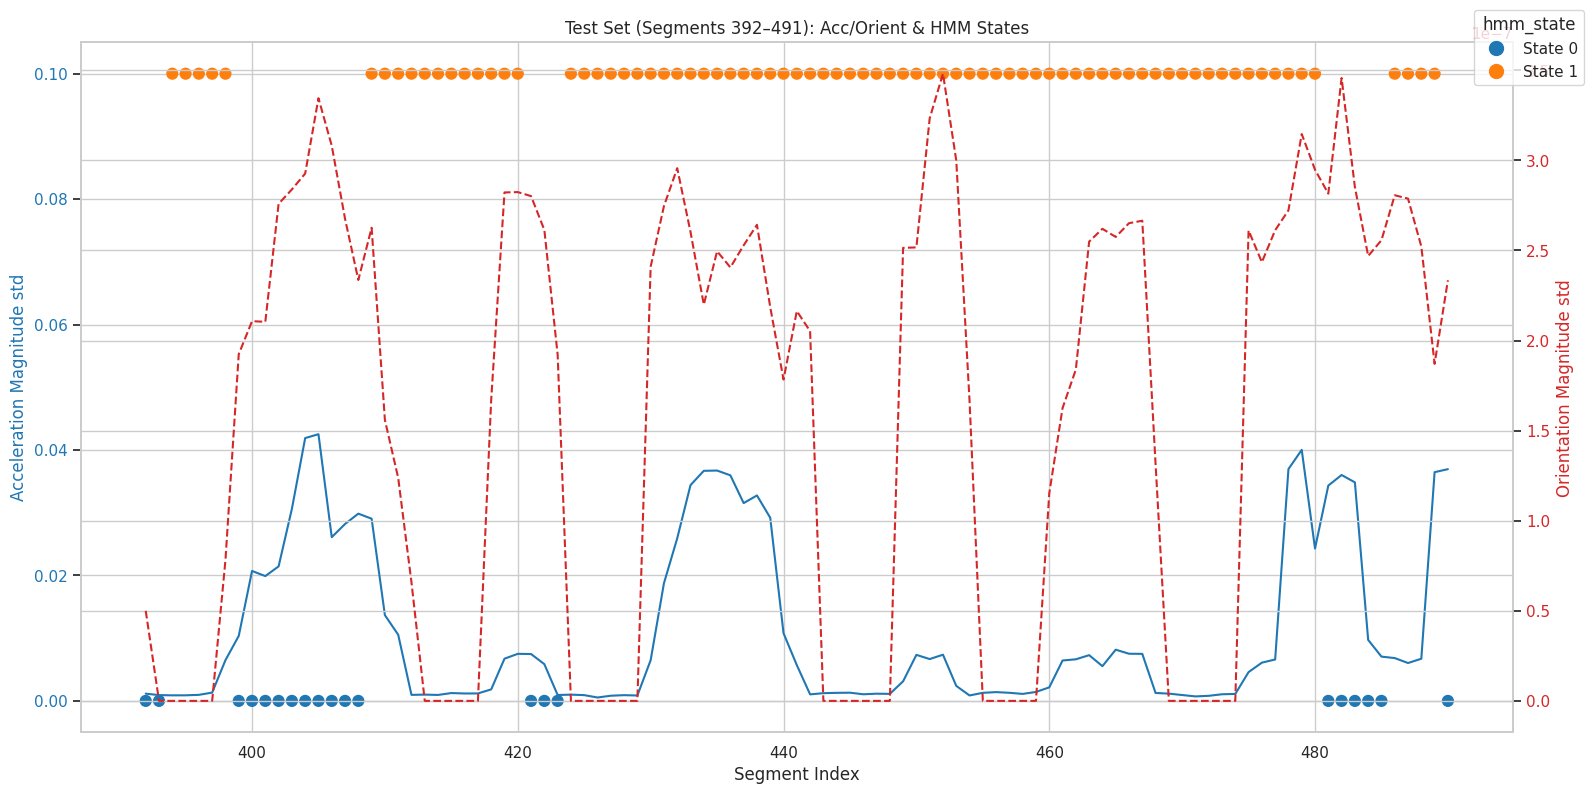

In [ ]:
# --- 10) Plot the Entire Test Set with HMM States Overlayed ---
plot_states_overlay(
    df=df_plot,
    start=0, end=len(df_plot),
    state_col='hmm_state',
    title='Test Set (Segments {}–{}): Acc/Orient & HMM States'.format(val_end, n)
)

**plot visualizes the detected hidden Markov model (HMM) states, highlighting periods of "pause" and "active" states within the dataset.The analysis includes the identification of:

Longest Pause: The longest contiguous period of quietness.

Longest Active: The longest period of activity.

Mini-Pauses: Short pauses, each less than 5 segments.

Inferred pause_state = 1; active_states = [0]
 Pause durations: mean=19.5, std=21.9, min=4, max=57
 Active durations: mean=4.2, std=3.2, min=1, max=10

Longest pause: (424, 480) (57 seg)
Longest active: (399, 408) (10 seg)
Mini-pauses (<5 seg): [(486, 489)]…


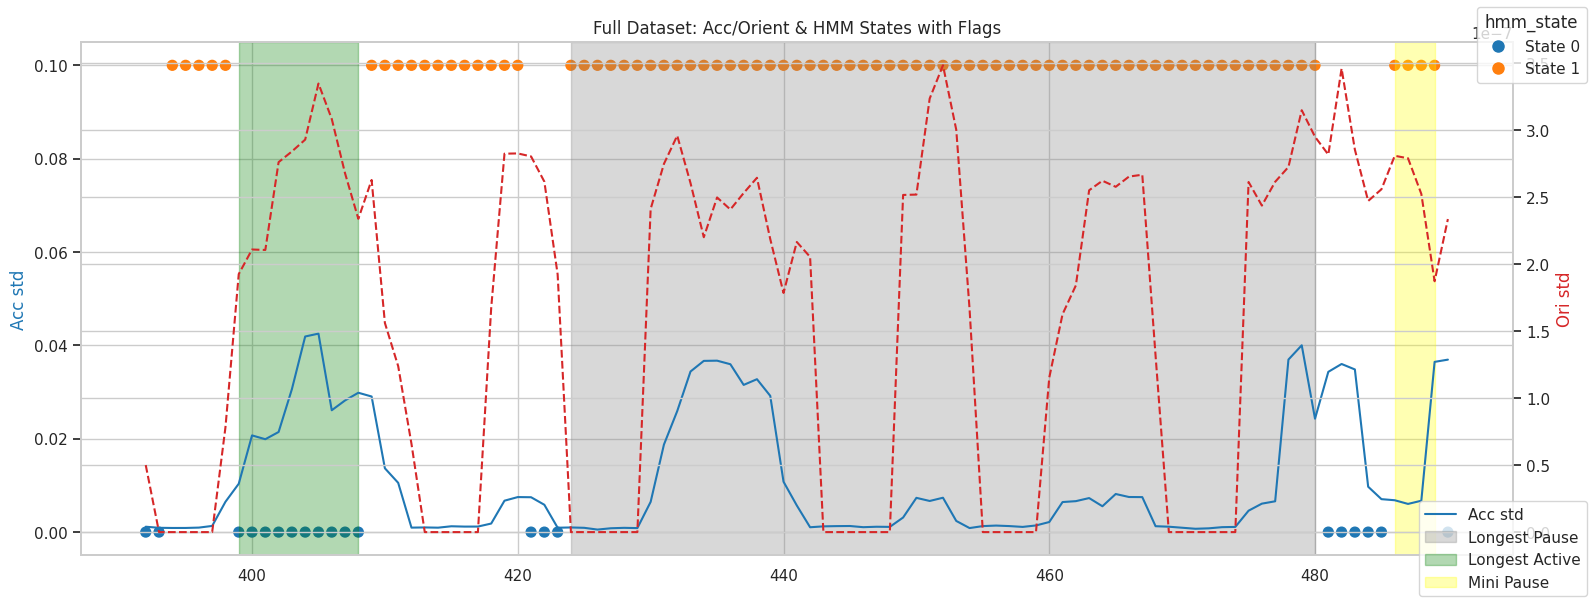

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.lines as mlines
from matplotlib.colors import ListedColormap

# --- 1) Infer Pause vs Active ---

state_stats = df_plot.groupby('hmm_state')[['acceleration_magnitude_std', 'orientation_magnitude_std']].mean()
activity_score = state_stats.mean(axis=1)
pause_state = activity_score.idxmin()
active_states = [s for s in state_stats.index if s != pause_state]

print(f"Inferred pause_state = {pause_state}; active_states = {active_states}")


# --- 2) get_state_runs ---
def get_state_runs(states, target_states, indices):
    runs = []
    start = None
    for i, s in enumerate(states):
        if s in target_states:
            if start is None:
                start = i
        else:
            if start is not None:
                runs.append((indices[start], indices[i-1]))  # Use indices for start and end
                start = None
    if start is not None:
        runs.append((indices[start], indices[len(states)-1]))  # End of last run
    return runs

# Extract hidden states from df_plot, but keep track of original indices
hidden = df_plot['hmm_state'].astype(int).values
indices = df_plot.index  # Keep track of indices

# --- 3) Find all runs of pause vs active (using the indices) ---
pause_runs = get_state_runs(hidden, [pause_state], indices)
active_runs = get_state_runs(hidden, active_states, indices)

# --- 4) Compute the durations ---
pause_durs = [e-s+1 for s, e in pause_runs]
active_durs = [e-s+1 for s, e in active_runs]

# --- 5) Find the longest & mini-pauses (<5 segments) ---
longest_pause = max(pause_runs, key=lambda t: t[1]-t[0]+1)
longest_active = max(active_runs, key=lambda t: t[1]-t[0]+1)
mini_pauses = [r for r, d in zip(pause_runs, pause_durs) if d < 5]

print(" Pause durations: mean={:.1f}, std={:.1f}, min={}, max={}".format(
    np.mean(pause_durs), np.std(pause_durs), np.min(pause_durs), np.max(pause_durs)))
print(" Active durations: mean={:.1f}, std={:.1f}, min={}, max={}\n".format(
    np.mean(active_durs), np.std(active_durs), np.min(active_durs), np.max(active_durs)))
print(f"Longest pause: {longest_pause} ({longest_pause[1]-longest_pause[0]+1} seg)")
print(f"Longest active: {longest_active} ({longest_active[1]-longest_active[0]+1} seg)")
print(f"Mini-pauses (<5 seg): {mini_pauses[:3]}…")

# --- 6) Plotting --- highlight these segments on the plot_states_overlay.
def plot_states_overlay_shaded(df, start, end, state_col, title, longest_pause, longest_active, mini_pauses):
    all_states = np.unique(df[state_col])
    cmap = ListedColormap(plt.cm.tab10.colors[:len(all_states)])
    fig, ax1 = plt.subplots(figsize=(16, 6))

    ax1.plot(df.index[start:end],
             df['acceleration_magnitude_std'][start:end],
             color='tab:blue', label='Acc std')
    ax1.set_ylabel('Acc std', color='tab:blue')
    ax2 = ax1.twinx()
    ax2.plot(df.index[start:end],
             df['orientation_magnitude_std'][start:end],
             color='tab:red', linestyle='--', label='Ori std')
    ax2.set_ylabel('Ori std', color='tab:red')

    # Scatter the state labels over the plot
    sc = ax1.scatter(df.index[start:end],
                     df[state_col][start:end]*0.1,
                     c=df[state_col][start:end],
                     cmap=cmap, s=50, vmin=all_states.min(), vmax=all_states.max())

    # Build legend for states
    handles = [mlines.Line2D([],[],marker='o',color=cmap(int(s)),
                              linestyle='None',markersize=8, label=f"State {int(s)}")
               for s in all_states]
    fig.legend(handles=handles, loc='upper right', title=state_col)
    plt.title(title)
    plt.tight_layout()

    # --- Highlight the segments ---
    # Shade the longest pause (gray), longest active (green), and mini-pauses (yellow)
    ax1.axvspan(longest_pause[0], longest_pause[1], color='gray', alpha=0.3, label='Longest Pause')
    ax1.axvspan(longest_active[0], longest_active[1], color='green', alpha=0.3, label='Longest Active')

    # Mark mini-pauses with <5 segments
    for s, e in mini_pauses[:3]:
        ax1.axvspan(s, e, color='yellow', alpha=0.3, label='Mini Pause')

    # Avoid duplicate legend entries
    handles, labels = ax1.get_legend_handles_labels()
    by_label = dict(zip(labels, handles))
    fig.legend(by_label.values(), by_label.keys(), loc='lower right')

    plt.show()

# --- 7) Plot full data, highlighting the flagged segments ---
plot_states_overlay_shaded(
    df=df_plot,
    start=0, end=len(df_plot),
    state_col='hmm_state',
    title='Full Dataset: Acc/Orient & HMM States with Flags',
    longest_pause=longest_pause,
    longest_active=longest_active,
    mini_pauses=mini_pauses
)


In [ ]:
features_df['hmm_state'] = y_hmm

In [ ]:
import numpy as np
import pandas as pd

pause_state = 1

def get_state_segments(states, target_state):
    segments = []
    start = None

    for i, s in enumerate(states):
        if s == target_state:
            if start is None:
                start = i
        else:
            if start is not None:
                segments.append((start, i - 1))
                start = None
    if start is not None:
        segments.append((start, len(states) - 1))
    return segments

hidden_states = features_df['hmm_state']

# Find pause segments
pause_segments = get_state_segments(hidden_states, pause_state)
pause_durations = [end - start + 1 for start, end in pause_segments]

# Summary
pause_df = pd.DataFrame(pause_durations, columns=['duration'])
print(f"Found {len(pause_segments)} pause segments (State {pause_state}).")
print("Pause Duration Stats:")
print(pause_df.describe())


print("\n First few pause segments (start, end):")
for i, (start, end) in enumerate(pause_segments[:5]):
    print(f"{i+1}: ({start}, {end})")


Found 17 pause segments (State 1).
Pause Duration Stats:
        duration
count  17.000000
mean   24.529412
std    26.194269
min     4.000000
25%     6.000000
50%    12.000000
75%    48.000000
max    87.000000

 First few pause segments (start, end):
1: (15, 101)
2: (105, 171)
3: (174, 179)
4: (184, 194)
5: (197, 207)


In [ ]:
# --- pause between and within the task---

pause_state = 1
pause_segments = []
start = None

for i, state in enumerate(hidden_states):
    if state == pause_state:
        if start is None:
            start = i
    else:
        if start is not None:
            pause_segments.append((start, i - 1))
            start = None

if start is not None:
    pause_segments.append((start, len(hidden_states) - 1))

# 2. Separate long (≥5) and mini (<5) pauses
long_pauses = [(start, end) for (start, end) in pause_segments if (end - start + 1) >= 5]
mini_pauses = [(start, end) for (start, end) in pause_segments if (end - start + 1) < 5]

# 3. Print results
print(f" Found {len(long_pauses)} likely BETWEEN-TASK pauses (≥5 segments):")
for i, (start, end) in enumerate(long_pauses):
    print(f"  {i+1}: Pause from {start} to {end} ({end - start + 1} segments)")

print(f"\n Found {len(mini_pauses)} likely WITHIN-TASK mini pauses (<5 segments):")
for i, (start, end) in enumerate(mini_pauses):
    print(f"  Mini Pause from {start} to {end} ({end - start + 1} segments)")


 Found 14 likely BETWEEN-TASK pauses (≥5 segments):
  1: Pause from 15 to 101 (87 segments)
  2: Pause from 105 to 171 (67 segments)
  3: Pause from 174 to 179 (6 segments)
  4: Pause from 184 to 194 (11 segments)
  5: Pause from 197 to 207 (11 segments)
  6: Pause from 211 to 259 (49 segments)
  7: Pause from 262 to 274 (13 segments)
  8: Pause from 279 to 293 (15 segments)
  9: Pause from 295 to 342 (48 segments)
  10: Pause from 347 to 361 (15 segments)
  11: Pause from 383 to 391 (9 segments)
  12: Pause from 394 to 398 (5 segments)
  13: Pause from 409 to 420 (12 segments)
  14: Pause from 424 to 480 (57 segments)

 Found 3 likely WITHIN-TASK mini pauses (<5 segments):
  Mini Pause from 364 to 367 (4 segments)
  Mini Pause from 371 to 374 (4 segments)
  Mini Pause from 486 to 489 (4 segments)


## LSTM